c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/2 Training:  35%|███▍      | 628/1801 [04:58<09:37,  2.03it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packag

Epoch 1/2  Loss: 0.2063  Train Acc: 0.9196  Val Acc: 0.9027


Epoch 2/2  Loss: 0.0529  Train Acc: 0.9833  Val Acc: 0.9148


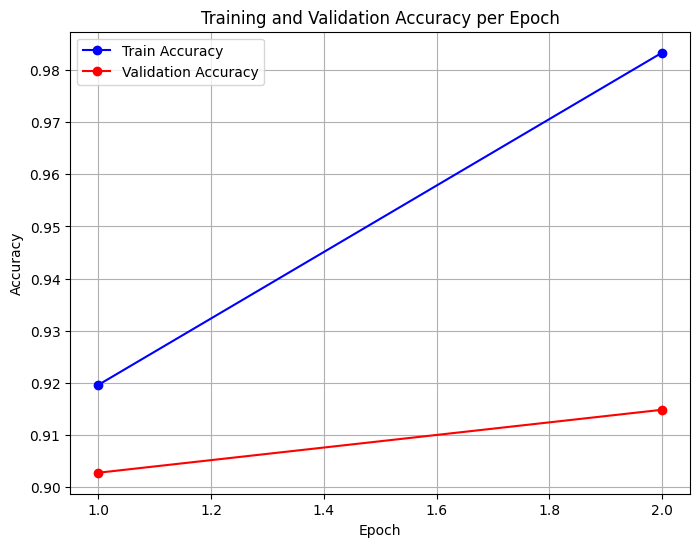

Extracting features for TSNE: 100%|██████████| 197/197 [00:31<00:00,  6.20it/s]


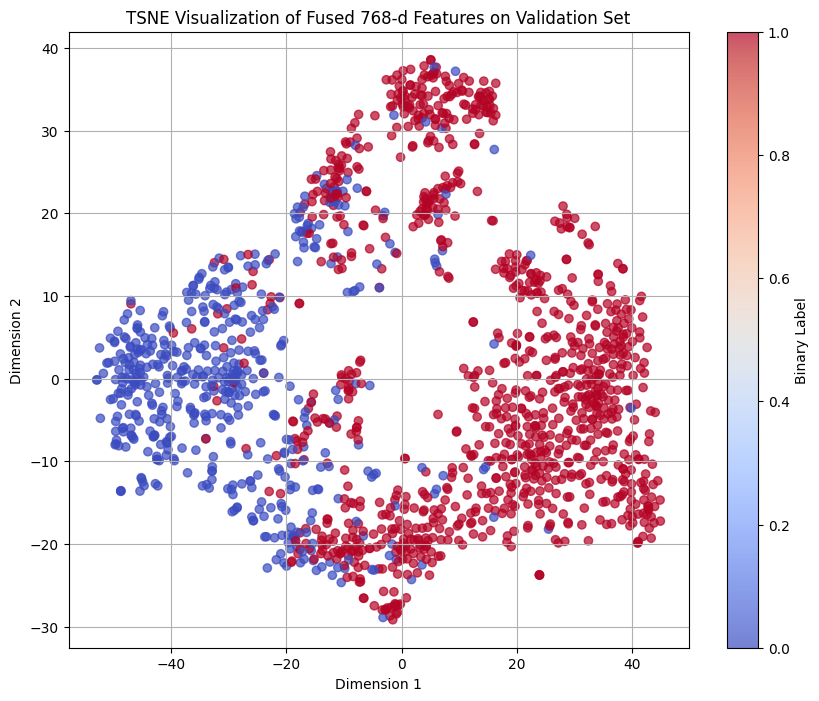

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel, ViTFeatureExtractor, ViTModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -------------------------
# 1. Load & Filter the Data
# -------------------------
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'

train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')

# Keep only samples with label_text_image == "Positive"
train_data = train_data[train_data['label_text_image'] == 'Positive'].reset_index(drop=True)
dev_data   = dev_data[dev_data['label_text_image'] == 'Positive'].reset_index(drop=True)

# Map textual label to binary label (informative: 1, not_informative: 0)
label_map = {"informative": 1, "not_informative": 0}
train_data['binary_label'] = train_data['label'].map(label_map)
dev_data['binary_label']   = dev_data['label'].map(label_map)

# -------------------------------------------------
# 2. Data Augmentation: Mixup for Images & Concatenation for Text
# -------------------------------------------------
augmented_rows = []
lambda_val = 0.5  # For mixup

for label in train_data['binary_label'].unique():
    # Shuffle group samples with the same binary label.
    group = train_data[train_data['binary_label'] == label].sample(frac=1, random_state=42)
    group = group.reset_index(drop=True)
    
    # Pair consecutive samples (if odd number, the last one is skipped)
    for i in range(0, len(group) - 1, 2):
        row1 = group.iloc[i]
        row2 = group.iloc[i+1]
        new_row = row1.copy()
        # Concatenate tweet texts with a space separator.
        new_row['tweet_text'] = row1['tweet_text'] + " " + row2['tweet_text']
        # For images, store a list of two image paths.
        new_row['image'] = [row1['image'], row2['image']]
        augmented_rows.append(new_row)

# Create augmented DataFrame and combine with original training data.
if augmented_rows:
    aug_train_data = pd.DataFrame(augmented_rows)
    combined_train_data = pd.concat([train_data, aug_train_data]).reset_index(drop=True)
else:
    combined_train_data = train_data.copy()

# -------------------------------------------------
# 3. Define Custom Dataset with On-the-fly Augmentation
# -------------------------------------------------
class CrisisDataset(Dataset):
    def __init__(self, dataframe, tokenizer, feature_extractor, target_size=(224, 224), max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.target_size = target_size
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tweet_text = row['tweet_text']
        image_info = row['image']  # Can be a string (original sample) or a list (augmented sample)
        label = int(row['binary_label'])
        
        # Process image: if augmented (list), perform mixup (pixelwise average)
        if isinstance(image_info, list):
            # Open and resize both images
            image1 = Image.open(image_info[0]).convert("RGB").resize(self.target_size)
            image2 = Image.open(image_info[1]).convert("RGB").resize(self.target_size)
            
            # Convert to numpy arrays for mixup
            image1_arr = np.array(image1).astype(np.float32)
            image2_arr = np.array(image2).astype(np.float32)
            
            # Pixelwise mixup using lambda_val = 0.5
            mixup_image_arr = lambda_val * image1_arr + (1 - lambda_val) * image2_arr
            mixup_image_arr = mixup_image_arr.astype(np.uint8)
            image = Image.fromarray(mixup_image_arr)
        else:
            # For non-augmented samples, ensure image file exists.
            if not os.path.exists(image_info):
                raise FileNotFoundError(f"Image file {image_info} not found.")
            image = Image.open(image_info).convert("RGB")
        
        # Tokenize text using BERT tokenizer.
        text_inputs = self.tokenizer(
            tweet_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        # Squeeze the batch dimension.
        text_inputs = {key: tensor.squeeze(0) for key, tensor in text_inputs.items()}
        
        # Process image using ViT feature extractor.
        image_inputs = self.feature_extractor(images=image, return_tensors="pt")
        # Squeeze batch dimension.
        image_inputs = {key: tensor.squeeze(0) for key, tensor in image_inputs.items()}
        
        # Add label.
        text_inputs['labels'] = torch.tensor(label, dtype=torch.float)
        # Merge dictionaries (they have non-overlapping keys: input_ids, attention_mask, pixel_values)
        text_inputs.update(image_inputs)
        
        return text_inputs

# -------------------------------------------------
# 4. Load Tokenizer, Feature Extractor, and Base Models
# -------------------------------------------------
# Load BERT tokenizer and model.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_model = BertModel.from_pretrained("bert-base-uncased")

# Load ViT feature extractor and model.
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
image_model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# -------------------------------------------------
# 5. Build the Fusion Classification Model with Gated Fusion and Dropout
# -------------------------------------------------
class BertVitFusionModel(nn.Module):
    def __init__(self, text_model, image_model, hidden_size=768, dropout_rate=0.1):
        super(BertVitFusionModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.gate_layer = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, 1)
    
    def forward(self, input_ids, attention_mask, pixel_values):
        # Text encoding via BERT
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        text_embeds = text_outputs.pooler_output  # (batch, hidden_size)
        
        # Image encoding via ViT: take the [CLS] token representation.
        image_outputs = self.image_model(pixel_values=pixel_values, return_dict=True)
        image_embeds = image_outputs.last_hidden_state[:, 0, :]  # (batch, hidden_size)
        
        # --- Gated fusion for multimodal representation ---
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))  # (batch, hidden_size)
        fused = gate * text_embeds + (1 - gate) * image_embeds  # (batch, hidden_size)
        multimodal_logits = self.classifier(self.dropout(fused))
        return multimodal_logits
    
    def extract_features(self, input_ids, attention_mask, pixel_values):
        # Feature extraction for visualization.
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        text_embeds = text_outputs.pooler_output
        
        image_outputs = self.image_model(pixel_values=pixel_values, return_dict=True)
        image_embeds = image_outputs.last_hidden_state[:, 0, :]
        
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))
        fused = gate * text_embeds + (1 - gate) * image_embeds
        return fused

# -------------------------------------------------
# 6. Prepare DataLoaders
# -------------------------------------------------
train_dataset = CrisisDataset(combined_train_data, tokenizer, feature_extractor)
val_dataset   = CrisisDataset(dev_data, tokenizer, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# -------------------------------------------------
# 7. Training Setup
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertVitFusionModel(text_model, image_model).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 2

train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * input_ids.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_acc_history.append(train_acc)
    avg_loss = running_loss / total

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values
            )
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {avg_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

# -------------------------------------------------
# 8. Plot Training and Validation Accuracy
# -------------------------------------------------
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_history, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 9. TSNE Visualization of Fused Features on Validation Set
# -------------------------------------------------
all_features = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Extracting features for TSNE"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        features = model.extract_features(input_ids, attention_mask, pixel_values)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels.numpy(), cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Binary Label')
plt.title("TSNE Visualization of Fused 768-d Features on Validation Set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


In [2]:
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -------------------------
# 1. Load and Prepare Test Data
# -------------------------
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_data = pd.read_csv(test_file_path, sep='\t')

# Keep only samples with label_text_image == "Positive"
test_data = test_data[test_data['label_text_image'] == 'Positive'].reset_index(drop=True)

# Map textual label to binary label (informative: 1, not_informative: 0)
label_map = {"informative": 1, "not_informative": 0}
test_data['binary_label'] = test_data['label'].map(label_map)

# -------------------------
# 2. Create Test Dataset and DataLoader
# -------------------------
test_dataset = CrisisDataset(test_data, tokenizer, feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# -------------------------
# 3. Run Inference on Test Data and Collect Predictions
# -------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)  # ground truth labels
        
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Convert logits to predictions using a threshold of 0.5.
        preds = (torch.sigmoid(logits) > 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -------------------------
# 4. Calculate Metrics
# -------------------------
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Precision: {:.4f}".format(precision))
print("Test Recall: {:.4f}".format(recall))
print("Test F1 Score: {:.4f}".format(f1))


Testing:   1%|          | 1/192 [00:00<00:47,  4.01it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing: 100%|██████████| 192/192 [00:38<00:00,  5.02it/s]

Test Accuracy: 0.9113
Test Precision: 0.9306
Test Recall: 0.9379
Test F1 Score: 0.9342
